In [1]:

import numpy as np
import cv2
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import training_temp
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
# from generate_sets import flatten_image
from matplotlib.colors import LinearSegmentedColormap


In [2]:
evaluate_kfolds = True

In [3]:
# Hyperparameters and settings
batch_size = 64
test_batch_size = 64
input_size = 1 # because there is only one channel 
output_size = 4
num_epochs = 10
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
# Load training, validation and training data

data_loader = torch.load('data_loader.pt')
valid_loader = torch.load('valid_loader.pt')
test_loader = torch.load('test_loader.pt')

# Move the data loaders to the desired device
data_loader.dataset.tensors = tuple(tensor.to(device) for tensor in data_loader.dataset.tensors)
valid_loader.dataset.tensors = tuple(tensor.to(device) for tensor in valid_loader.dataset.tensors)
test_loader.dataset.tensors = tuple(tensor.to(device) for tensor in test_loader.dataset.tensors)


In [12]:
# load model architectures from training_temp.py
model1 = training_temp.CNN()
model2 = training_temp.CNN2()
model3 = training_temp.CNN3()

model1.to(device)
model2.to(device)
model3.to(device)


CNN3(
  (conv_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=3136, out_features=1000, bias=True)
    (2): Re

In [13]:
#load the weights of the models
model1.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(8)/CNN.pth', map_location=device))
model2.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(8)/CNN2.pth', map_location=device))
model3.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(8)/CNN3.pth', map_location=device))

<All keys matched successfully>

In [6]:
# make confusion matrix based on test results
def confusion_matrix_data(model, test_loader):
    model.eval()
    predictions = []
    actual_labels = []
    f1_list = []
    recall_list = []
    precision_list = []
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
        # print(predictions)
        # print(actual_labels)

    return predictions, actual_labels

In [7]:
def calculate_model_performance_stats(model, test_loader, show_matrix=True):
    data_out = {}

    predictions, actual_labels = confusion_matrix_data(model, test_loader)

    data_out['name'] = model.name
    data_out['predictions'] = predictions
    data_out['actual_labels'] = actual_labels
    data_out['f1_macro'] = sklearn.metrics.f1_score(actual_labels, predictions, average='macro')
    data_out['f1_micro'] = sklearn.metrics.f1_score(actual_labels, predictions, average='micro')
    data_out['recall_macro'] = sklearn.metrics.recall_score(actual_labels, predictions, average='macro')
    data_out['recall_micro'] = sklearn.metrics.recall_score(actual_labels, predictions, average='micro')
    data_out['precision_macro'] = sklearn.metrics.precision_score(actual_labels, predictions, average='macro')
    data_out['precision_micro'] = sklearn.metrics.precision_score(actual_labels, predictions, average='micro')
    data_out['accuracy'] = sklearn.metrics.accuracy_score(actual_labels, predictions)
    
    if (show_matrix):
        cf_matrix = sklearn.metrics.confusion_matrix(actual_labels, predictions)
        classes = {'focused': 0, 'happy': 1, 'neutral': 2, 'surprised': 3}
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [key for key in classes],
                            columns = [key for key in classes])

        plt.figure(figsize = (12,7))
        #set labels

        # https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
        #add label to heatmap
        plt.title('Confusion Matrix for %s'%(model.name))
        
        #colour mapping for heatmap
        # colour_gradient = ["#E72A24", "#FF8000" ,"#D2C631", "#31B329", "#00FFFF"] # red, yellow, green, cyan, blue
        colour_gradient = ["#FFFFFF", "#9ae0f4", "#003153"] # red, yellow, green, cyan, blue
        # positions = [0.0, 0.10, 0.30, 0.50, 1.0]
        positions = [0.0, 0.5, 1.0] 
        custom_cmap = LinearSegmentedColormap.from_list("blue-to-red", list(zip(positions, colour_gradient)))
        
        sn.heatmap(df_cm, annot=True, cmap = custom_cmap).set(xlabel='Predicted Class', ylabel='Actual Class')
        plt.savefig('matrix_%s.png'%(model.name))
    return data_out

Macro precision for :  CNN 0.9609773107239837
Micro precision for :  CNN 0.962
Macro recall for :  CNN 0.9606655518394649
Micro recall for :  CNN 0.962
Macro F1 for :  CNN 0.9607961842425079
Micro F1 for :  CNN 0.962
Accuracy for :  CNN 0.962
__________________________________________________

Macro precision for :  CNN2 0.9691475387168141
Micro precision for :  CNN2 0.97
Macro recall for :  CNN2 0.968685618729097
Micro recall for :  CNN2 0.97
Macro F1 for :  CNN2 0.9688617374544148
Micro F1 for :  CNN2 0.97
Accuracy for :  CNN2 0.97
__________________________________________________

Macro precision for :  CNN3 0.9619492656875834
Micro precision for :  CNN3 0.96
Macro recall for :  CNN3 0.9598260869565217
Micro recall for :  CNN3 0.96
Macro F1 for :  CNN3 0.9582869855394883
Micro F1 for :  CNN3 0.96
Accuracy for :  CNN3 0.96
__________________________________________________



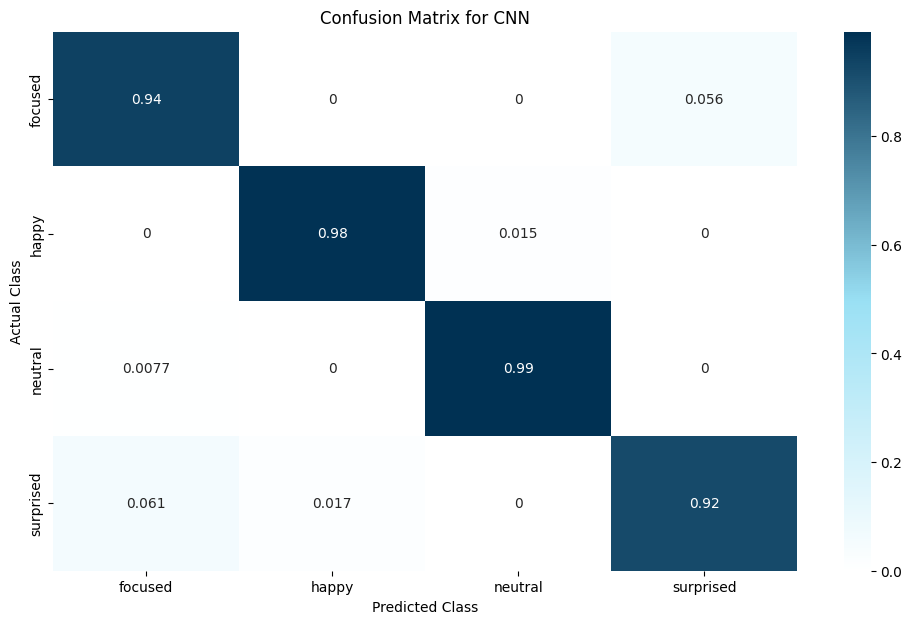

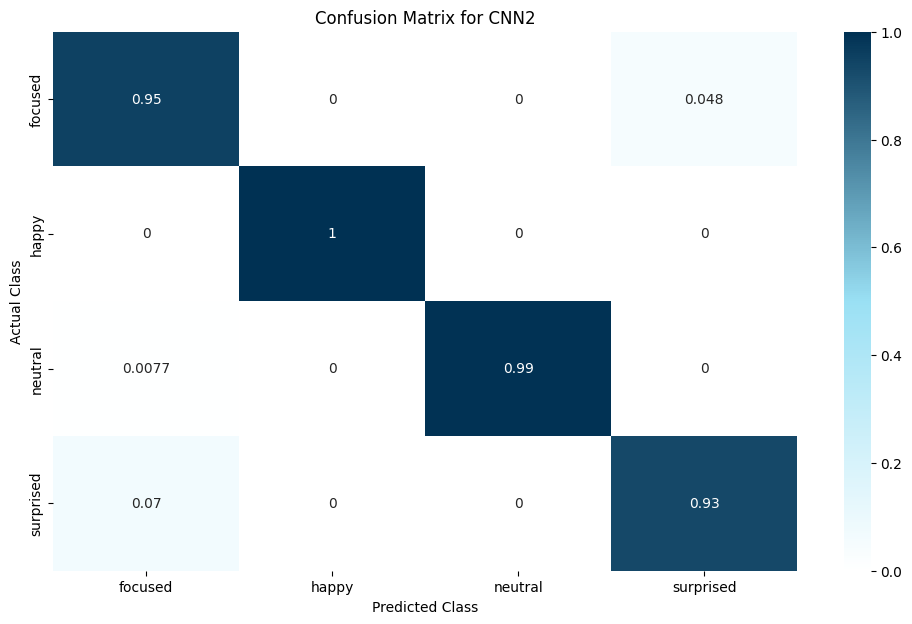

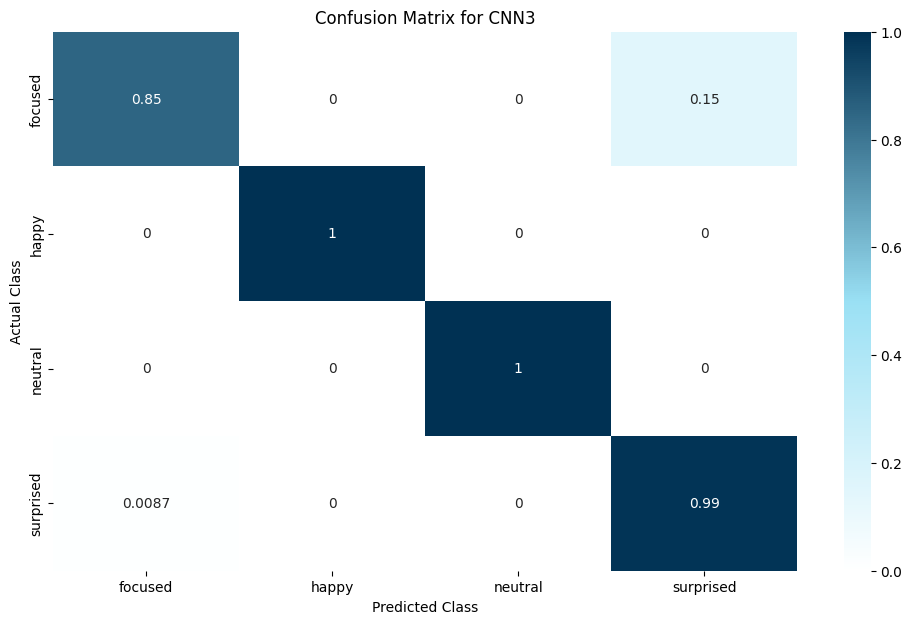

In [14]:
# printing the performance stats for each model
#NOTE: Average on micro would always be equal to accuracy since all classes have equal weights in the case of the project.
data_dicts = {'name': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'f1_micro': [], 'f1_macro': [], 'accuracy': []}
for model in [model1, model2, model3]:
    data_out = calculate_model_performance_stats(model, test_loader)
    print("Macro precision for : ", model.name, data_out['precision_macro'])
    print("Micro precision for : ", model.name, data_out['precision_micro'])
    print("Macro recall for : ", model.name, data_out['recall_macro'])
    print("Micro recall for : ", model.name, data_out['recall_micro'])
    print("Macro F1 for : ", model.name, data_out['f1_macro'])
    print("Micro F1 for : ", model.name, data_out['f1_micro'])
    print("Accuracy for : ", model.name, data_out['accuracy'])
    print("__________________________________________________\n")

    for key in data_dicts.keys():
        data_dicts[key].append(data_out[key])

In [15]:
def create_df_stats(data_dicts):
    #tabulating the CNN metrics using pandas
    df = pd.DataFrame(data_dicts)

    #set index to "name" column which is for CNN names
    df = df.set_index('name', inplace=False)

    #reorder columns
    df = df[['precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro', 'accuracy']]
    return df


In [16]:
df = create_df_stats(data_dicts)
display(df)

,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accuracy
name,,,,,,,
CNN,0.960977,0.960666,0.960796,0.962,0.962,0.962,0.962
CNN2,0.969148,0.968686,0.968862,0.970,0.970,0.970,0.970
CNN3,0.961949,0.959826,0.958287,0.960,0.960,0.960,0.960


In [91]:
#saving the CNN metrics to a .csv file
df.to_csv("evaluation_stats.csv")

In [17]:
def evaluate_k_fold(model, test_loader, data_dicts):
    model = model
    
    data_out = calculate_model_performance_stats(model, test_loader, show_matrix=False)
    for key in data_dicts.keys():
        data_dicts[key].append(data_out[key])
    

In [18]:
#run for the kfold models
if (evaluate_kfolds):
    data_dicts = {'name': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'f1_micro': [], 'f1_macro': [], 'accuracy': []}
    for i in range(1, 11):

        # load model architectures from training_temp.py
        model = training_temp.CNN2()

        model.to(device)

        data_loader = torch.load('kfolds/data_loader_kfold%s.pt'%(i))
        valid_loader = torch.load('kfolds/valid_loader_kfold%s.pt'%(i))
        test_loader = torch.load('kfolds/test_loader_kfold%s.pt'%(i))

        # Move the data loaders to the desired device
        data_loader.dataset.tensors = tuple(tensor.to(device) for tensor in data_loader.dataset.tensors)
        valid_loader.dataset.tensors = tuple(tensor.to(device) for tensor in valid_loader.dataset.tensors)
        test_loader.dataset.tensors = tuple(tensor.to(device) for tensor in test_loader.dataset.tensors)

        #load the weights of the model
        model.load_state_dict(torch.load('trained_k_folds/CNN_kfold_CNN%s_%s.pth'%(2, i), map_location=device))

        evaluate_k_fold(model, test_loader, data_dicts)

        del model, data_loader, valid_loader, test_loader

        # Clear the cache
        torch.cuda.empty_cache()
    
    df = create_df_stats(data_dicts)
    # number index from 1 to 10
    df.index = np.arange(1, 11)
    
    #group by each column and calculate the average
    df.loc['Average'] = df.mean()
    
    display(df)

,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accuracy
1,0.946172,0.947987,0.946825,0.948,0.948,0.948,0.948
2,0.922480,0.911658,0.916103,0.912,0.912,0.912,0.912
3,0.872063,0.873288,0.871049,0.872,0.872,0.872,0.872
4,0.923910,0.915934,0.917349,0.924,0.924,0.924,0.924
5,0.934620,0.921974,0.920860,0.922,0.922,0.922,0.922
6,0.915742,0.926136,0.917399,0.914,0.914,0.914,0.914
7,0.893769,0.890148,0.889836,0.900,0.900,0.900,0.900
8,0.917036,0.916591,0.915635,0.918,0.918,0.918,0.918
9,0.946555,0.949777,0.947068,0.948,0.948,0.948,0.948
10,0.932341,0.928906,0.929498,0.932,0.932,0.932,0.932


In [19]:
def flatten_image(image_name, subfolder):
    img = cv2.imread("../concat_data_tagged/%s/"%(subfolder) + image_name, 0)
    return img

In [20]:
def get_image_subfolder(image_name):
    # expand folder ../concat_data_tagged
    for subfolder in os.listdir('../concat_data_tagged'):
        if image_name in os.listdir('../concat_data_tagged/' + subfolder):
            return subfolder
        
    

In [21]:
def get_race_category(image_name):
    #     tags = ['white', 'black', 'asian', 'hispanic', 'other_race']
    if '_white' in image_name:
        return 'white'
    elif '_black' in image_name:
        return 'black'
    elif '_asian' in image_name:
        return 'asian'
    elif '_hispanic' in image_name:
        return 'hispanic'
    elif '_other_race' in image_name:
        return 'other_race'
    else:
        print('Error: Could not determine the race category of the image: ', image_name)
        return None
def get_age_category(image_name):
        # elif group == 'age':
    #     tags = ['young', 'adult', 'old']

    if '_young' in image_name:
        return 'young'
    elif '_adult' in image_name:
        return 'adult'
    elif '_old' in image_name:
        return 'old'
    else:
        print('Error: Could not determine the age category of the image: ', image_name)
        return None
def get_gender_category(image_name):
        # elif group == 'gender':
    #     tags = ['male', 'female', 'other_gender']
    if '_male' in image_name:
        return 'male'
    elif '_female' in image_name:
        return 'female'
    elif '_other_gender' in image_name:
        return 'other_gender'
    else:
        print('Error: Could not determine the gender category of the image: ', image_name)
        return None

In [22]:
def test_individual_image(model, image_name, category, labels, read_custom_path = ''):
    if (read_custom_path != ''):
        img = cv2.imread(read_custom_path, 0)
        image_name = read_custom_path
        #save the image
    else:
        img = cv2.imread("../concat_data_tagged/%s/%s" % (category, image_name), 0)
    
    #resize to 48x48 pixels
    img = cv2.resize(img, (48, 48))



    #if image 3 channel convert to 1 channel
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cv2.imwrite("image_mod.jpg", img)
    
    # Convert image to tensor and add batch and channel dimensions
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Get label tensor
    

    label_tensor = torch.tensor(labels[category], dtype=torch.long)

    # Forward pass for the single image
    img_tensor = img_tensor.to(device)
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)

    # Print results
    # print("Predicted:", predicted.item(), "(", reverse_labels[predicted.item()], ")")
    # print("Actual:", label_tensor.item(), "(", reverse_labels[label_tensor.item()], ")")
    # print("Image:", image_name)
    # print("Category:", category)
    # print("///////")
    
    return predicted.item()

In [23]:
# read test_set_images_categories.txt and send to string
# run for the final model (non-kfold)
# load model architectures from training_temp.py
model = training_temp.CNN2()
model.to(device)
#load the weights of the model
model.load_state_dict(torch.load('../models/augmented_greyscale_batch_size(8)/CNN2.pth', map_location=device))
test_set_images_categories = open('test_set_images_categories.txt', 'r').read()
images_to_read = test_set_images_categories.split(',')
dict_data = {'image_name': [], 
             'gender': [],
             'race': [],
             'age': [],
             'class': [],
             'class_num': [],
             'prediction_num': [],
             'prediction': [],
            }

labels = {'focused': 0, 'happy': 1, 'neutral': 2, 'surprised': 3}
reverse_labels = {0: 'focused', 1: 'happy', 2: 'neutral', 3: 'surprised'}

for image_to_read in images_to_read:
    
    image_expression = get_image_subfolder(image_to_read)
    gender_category = get_gender_category(image_to_read)
    race_category = get_race_category(image_to_read)
    age_category = get_age_category(image_to_read)
    prediction_num = test_individual_image(model, image_to_read, image_expression, labels)



    img = flatten_image(image_to_read, image_expression)
    dict_data['image_name'].append(image_to_read)
    dict_data['gender'].append(gender_category)
    dict_data['race'].append(race_category)
    dict_data['age'].append(age_category)
    dict_data['class'].append(image_expression)
    dict_data['class_num'].append(labels[image_expression])
    dict_data['prediction_num'].append(prediction_num)
    dict_data['prediction'].append(reverse_labels[prediction_num])

df = pd.DataFrame(dict_data)



In [24]:
def get_f1_recall_precision_accuracy_from_category(df_in, category, subcategories):
    dict_stats = {}
    for subcategory in subcategories:
        dict_stats[subcategory] = {}
        df_temp = df_in[df_in[category] == subcategory]
        dict_temp = df_temp.to_dict(orient='list')
        dict_stats[subcategory]['f1_macro'] = sklearn.metrics.f1_score(dict_temp['class_num'], dict_temp['prediction_num'], average='macro', zero_division=0)
        dict_stats[subcategory]['recall_macro'] = sklearn.metrics.recall_score(dict_temp['class_num'], dict_temp['prediction_num'], average='macro', zero_division=0)
        dict_stats[subcategory]['precision_macro'] = sklearn.metrics.precision_score(dict_temp['class_num'], dict_temp['prediction_num'], average='macro', zero_division=0)
        dict_stats[subcategory]['accuracy'] = sklearn.metrics.accuracy_score(dict_temp['class_num'], dict_temp['prediction_num'])
        dict_stats[subcategory]['count'] = len(dict_temp['class_num'])
    df_test = pd.DataFrame(dict_stats)
    #flip axis
    df_test = df_test.T
    # add averages
    df_test.loc['Average'] = df_test.mean()
    return df_test
            

In [25]:
stats_race = get_f1_recall_precision_accuracy_from_category(df, 'race', ['white', 'black', 'asian', 'hispanic', 'other_race'])
stats_gender = get_f1_recall_precision_accuracy_from_category(df, 'gender', ['male', 'female', 'other_gender'])
stats_age = get_f1_recall_precision_accuracy_from_category(df, 'age', ['young', 'adult', 'old'])

df_stats_combined = pd.concat([stats_race, stats_gender, stats_age])
display(df_stats_combined)

,f1_macro,recall_macro,precision_macro,accuracy,count
white,0.968505,0.969978,0.968137,0.963918,194.0
black,1.000000,1.000000,1.000000,1.000000,54.0
asian,0.654762,0.643939,0.666667,0.948718,39.0
hispanic,1.000000,1.000000,1.000000,1.000000,10.0
other_race,0.400000,0.333333,0.500000,0.666667,3.0
Average,0.804653,0.789450,0.826961,0.915860,60.0
male,0.958568,0.975000,0.947573,0.968553,159.0
female,0.973317,0.980769,0.967844,0.975410,122.0
other_gender,0.472222,0.447368,0.500000,0.894737,19.0
Average,0.801369,0.801046,0.805139,0.946233,100.0
